# Creating the Bathymetry

Name: Mike Wood

Date: 10/22/24

In this notebook, I describe the creation of the bathymetry file I will use in my model.

First, import packages to re-create and visualize the model grid here:

### Bathymetry Source File
To generate the bathymetry for my model, I first obtained a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

Specifically, I requested a subset covering my grid ranging from 99-122$^{\circ}$E in longitude and 2-25$^{\circ}$N in latitude, and I stored the bathymetry as `GEBCO_Bathymetry_SEA.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

In [4]:
# read in the bathymetry grid
file_path = '/Users/eddie/cs185c_fall2024/project/input/GEBCO_Bathymetry_SEA.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

In [5]:
# recreate the model grid - see previous notebook on creating the model grid for details
delX = 1/13
delY = 1/14
xgOrigin = 99
ygOrigin = 2
n_rows = 320
n_cols = 300

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

In [6]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [7]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

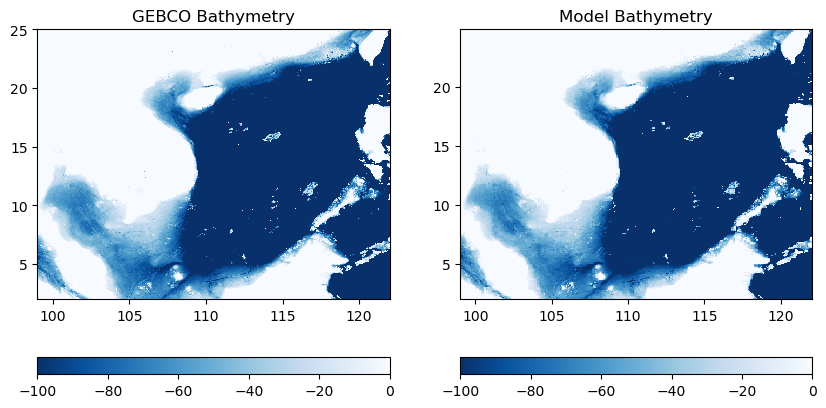

In [10]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-100, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-100, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

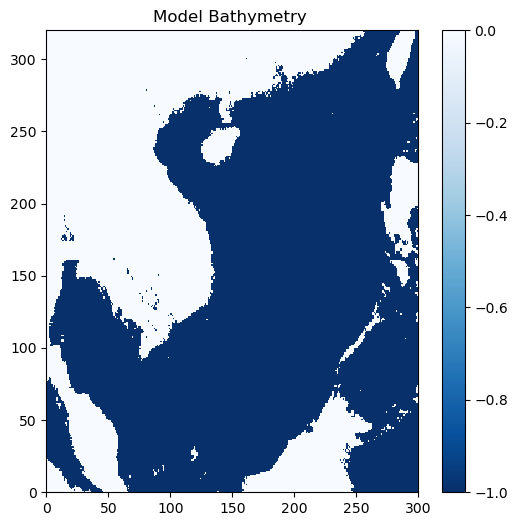

In [7]:
plt.figure(figsize=(6,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

It's good that there are no unconnected region in the domain. Moreover, there are a lot of shallow bathymetry regions in my area. However, they are my region of interest so I will keep it the same.

In [12]:
output_file = 'SEA_bathymetry.bin'
Model_bathy.ravel('C').astype('>f4').tofile(output_file)

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'SEA_bathymetry.bin,
 &
```